In this file I will implement two Random Forest classifiers, SHAP explanations and a system to connect the SHAP explanations to past event sthrough the comparmental models in MathematicalModel.ipynb  ...

NOTE: This is a file similar to ClassifierandExplainer but it has more code and methods in order to obtain statistics and evaluate the model and explanations, which in the other file is not existing since it is just the implementation

Import statements:

In [15]:
import os
import json
from datetime import datetime, timedelta

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_curve,roc_auc_score,classification_report)

import matplotlib.pyplot as plt
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np



import joblib 
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

In [16]:
#Data obtained from the mathematical models

preprocessed = "C:/Users/emmxc/OneDrive/Escritorio/thesis/FinalProjectThesis/MachineLearning/kinetics.csv"
df = pd.read_csv(preprocessed, sep="\t")

print("Hyperglycemia positives:", df['Hyperglycemia'].sum())
print("Hyperglycemia negatives:", (df['Hyperglycemia'] == 0).sum())

print("Hypoglycemia positives:", df['Hypoglycemia'].sum())
print("Hypoglycemia negatives:", (df['Hypoglycemia'] == 0).sum())

df_original = df.copy()


Hyperglycemia positives: 1599
Hyperglycemia negatives: 1089
Hypoglycemia positives: 126
Hypoglycemia negatives: 2562


To plot features original df to see if the explanations made sense....


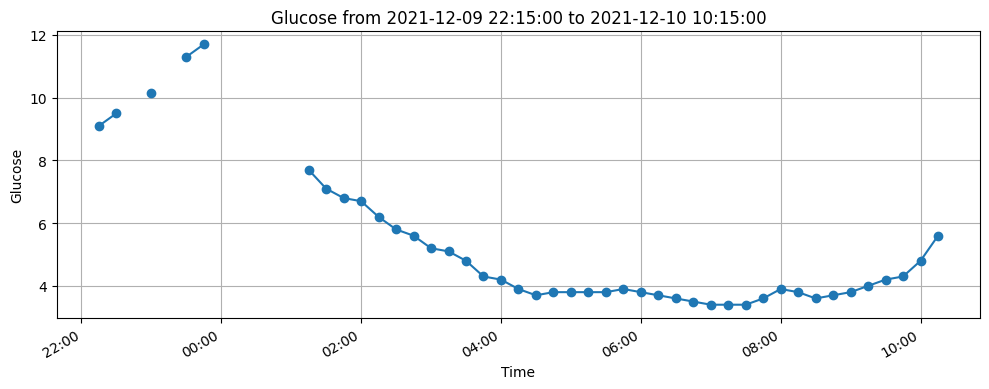

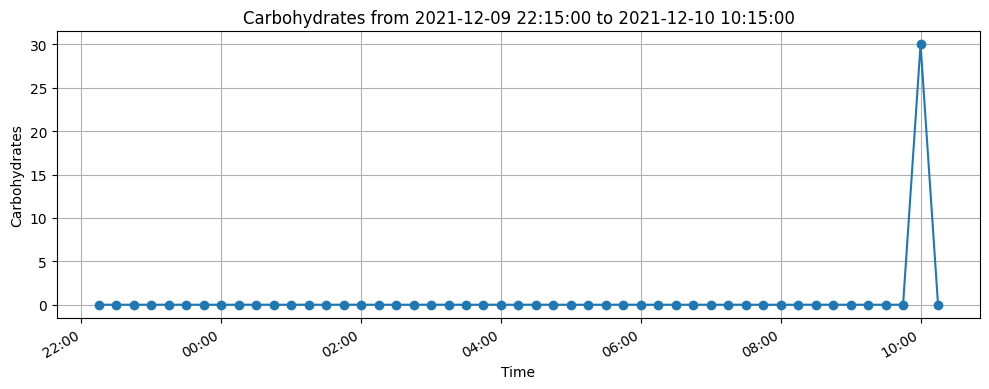

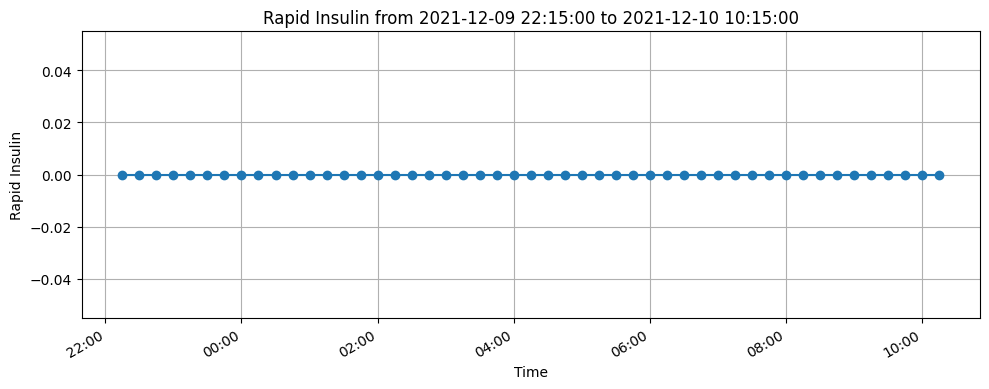

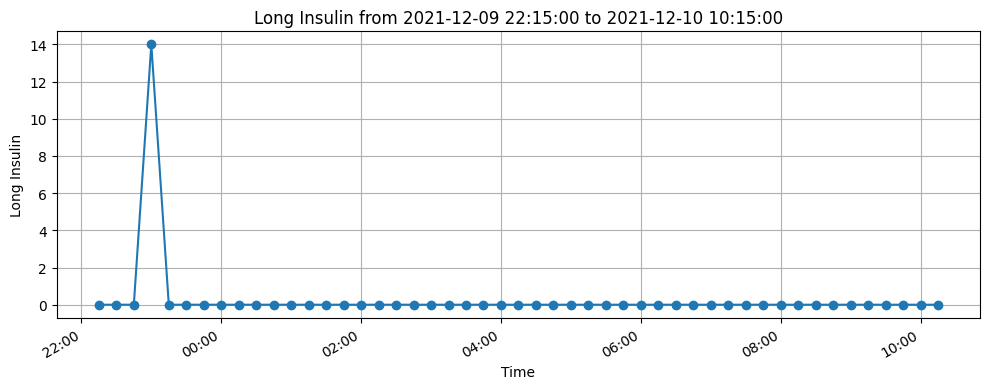

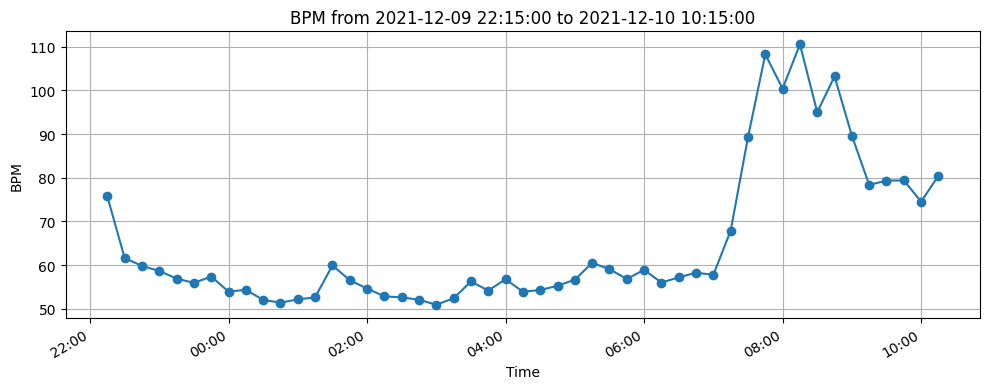

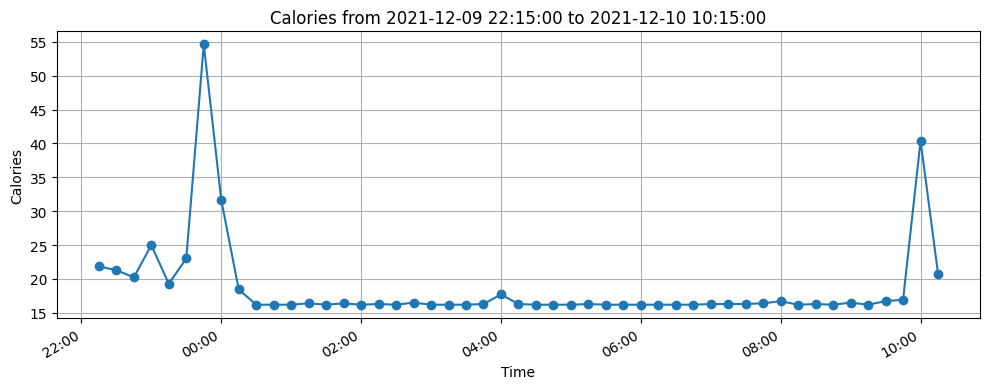

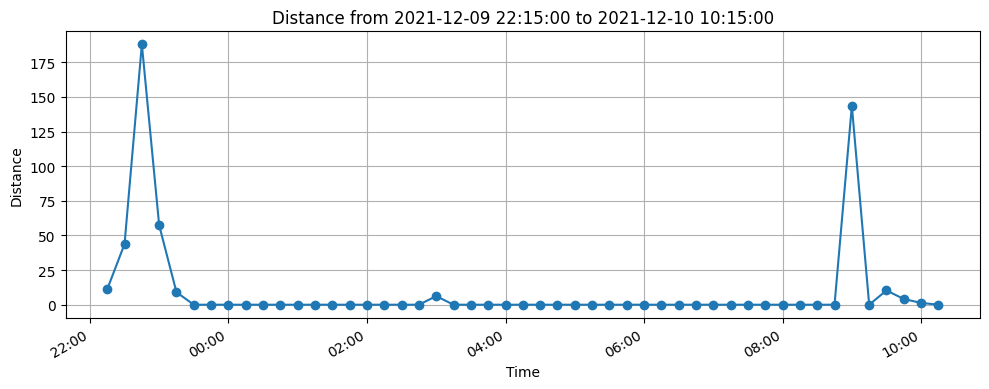

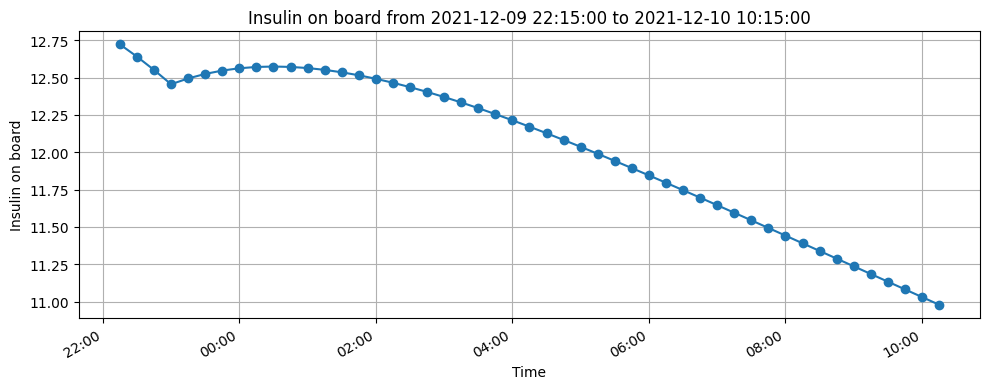

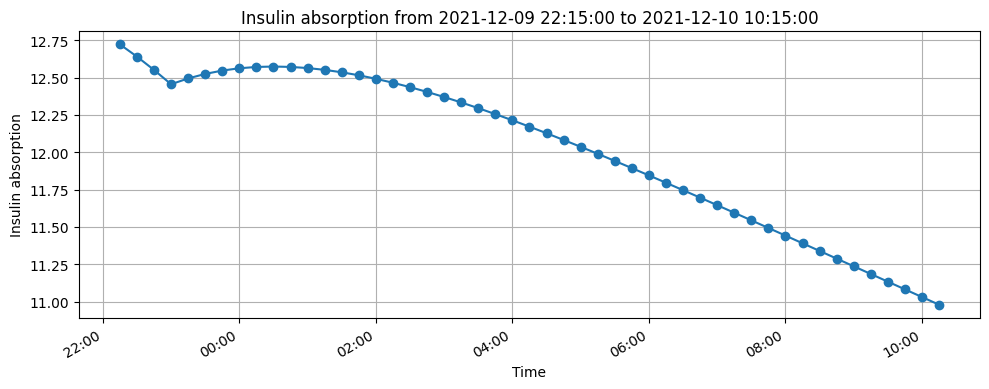

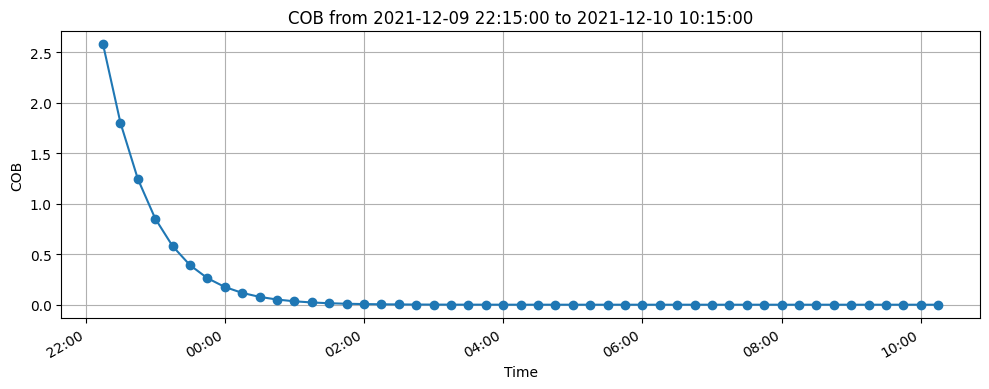

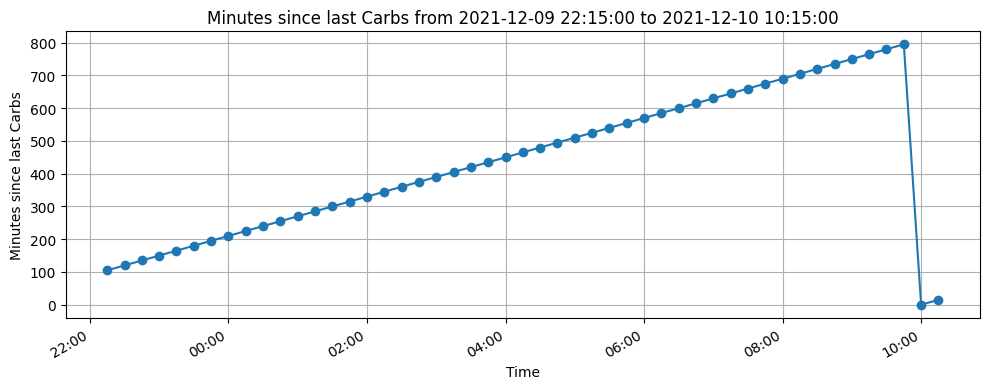

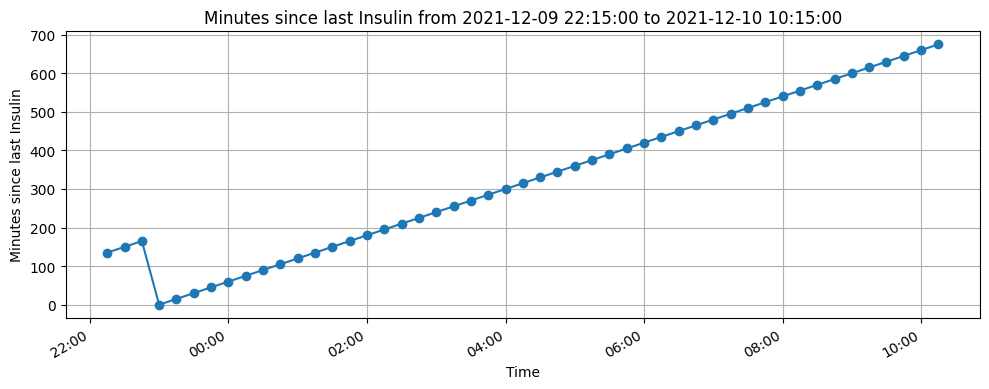

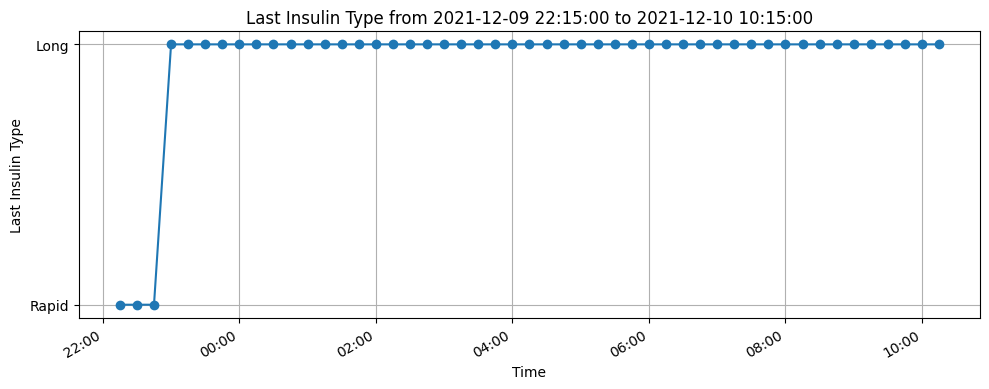

In [66]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

def plot_features_around_time(df, t, window_hours=6):
    df['Time'] = pd.to_datetime(df['Time'])  # ensure datetime type
    t = pd.to_datetime(t)

    start_time = t - pd.Timedelta(hours=window_hours)
    end_time = t + pd.Timedelta(hours=window_hours)

    df_window = df[(df['Time'] >= start_time) & (df['Time'] <= end_time)]

    if df_window.empty:
        print(f"No data between {start_time} and {end_time}")
        return

    exclude_cols = ['Time', 'Hyperglycemia', 'Hypoglycemia']
    features = [col for col in df.columns if col not in exclude_cols]

    for feat in features:
        plt.figure(figsize=(10, 4))
        plt.plot(df_window['Time'], df_window[feat], marker='o')
        plt.title(f"{feat} from {start_time} to {end_time}")
        plt.xlabel("Time")
        plt.ylabel(feat)
        plt.grid(True)

        # Format x-axis to show only HH:MM
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        plt.gcf().autofmt_xdate()  # Rotate date labels

        plt.tight_layout()
        plt.show()

# Example usage:
plot_features_around_time(df, "2021-12-10 04:15:00")



For the machine learning classifier I implement Random Forest. Writing this towards the end I regret not trying XBoost too because it could have brought better results, but the focus is not to improve the model's accuracy but to obtain good event explanations from it:

We want the input of the model to be the attribute of each feature per time step for the last 2 hours t-15,t-30 etc etc. And the output columns of hyperglycemia or hypoglycemia.

Parameters setup:

It focuses on these features: 'Glucose', 'BPM' (heart rate), 'Distance', 'Calories', 'Insulin on board', 'COB' (Carbs On Board).

Uses a window size of 8 time points (each time point represents 15 minutes, so 8 x 15 = 2 hours).

It tries to predict 15 minutes ahead (step_ahead = 1).

The target is whether hyperglycemia will happen (Glucose > 6.9 mmol/L).

In [41]:
def build_windowed_dataset(df, prediction_horizon, window_minutes=120, interval_minutes=15):
    """
    For each timepoint in df, build a feature vector concatenating the past window_minutes
    of data at interval_minutes intervals (or less at start if insufficient data).
    Also compute hyper/hypoglycemia label at prediction_horizon minutes ahead.
    Keeps the corresponding 'Time' of the current row as a column.

    Returns:
    - df_windows: DataFrame of concatenated features + labels + Time column
    """
    features = ['Glucose', 'BPM', 'Distance', 'Calories', 'Insulin on board', 'COB']
    step_ahead = prediction_horizon // interval_minutes
    window_size = window_minutes // interval_minutes

    df = df.sort_values('Time').reset_index(drop=False)
    df['Glucose_future'] = df['Glucose'].shift(-step_ahead)
    df['Hyperglycemia'] = (df['Glucose_future'] > 6.9).astype(int)
    df['Hypoglycemia'] = (df['Glucose_future'] < 3.9).astype(int)

    X_rows = []
    y_hyper = []
    y_hypo = []
    times = []

    for i in range(len(df) - step_ahead):
        start_idx = max(0, i - window_size + 1)
        window_df = df.iloc[start_idx:i+1][features]

        # Pad if smaller
        if len(window_df) < window_size:
            padding = pd.DataFrame(np.nan, index=range(window_size - len(window_df)), columns=features)
            window_df = pd.concat([padding, window_df], ignore_index=True)

        # Skip windows with NaNs
        if window_df.isnull().values.any():
            continue

        X_rows.append(window_df.values.flatten())
        y_hyper.append(df.iloc[i + step_ahead]['Hyperglycemia'])
        y_hypo.append(df.iloc[i + step_ahead]['Hypoglycemia'])

    # Create column names
    col_names = []
    for lag in range(window_size):
        time_offset = (window_size - lag - 1) * interval_minutes  # from farthest to closest
        for feat in features:
            col_names.append(f"{feat}_t-{time_offset}min")

    df_windows = pd.DataFrame(X_rows, columns=col_names)
    df_windows['Outcome_Hyperglycemia'] = y_hyper
    df_windows['Outcome_Hypoglycemia'] = y_hypo

    return df_windows




Now we will train and test a Random forest to predict Hyperglycemia and Hypoglycemia

In [42]:
prediction_horizons = [15, 30, 60, 120]  # in minutes

dfs = {}
for horizon in prediction_horizons:
    dftemp = build_windowed_dataset(df,horizon)
    dfs[horizon] = dftemp



    

In [44]:
data_splits = {}

for horizon in prediction_horizons:
    df_combined = build_windowed_dataset(df, horizon)

    # Features (X) and labels (y) for hyper and hypo
    X = df_combined.drop(columns=['Outcome_Hyperglycemia', 'Outcome_Hypoglycemia'])
    y_hyper = df_combined['Outcome_Hyperglycemia']
    y_hypo = df_combined['Outcome_Hypoglycemia']

    # Split once using hyperglycemia labels and stratify on it (or you can choose other strategy)
    X_train, X_test, y_hyper_train, y_hyper_test, y_hypo_train, y_hypo_test = train_test_split(
        X, y_hyper, y_hypo, test_size=0.3, random_state=42, stratify=y_hypo
    )

    # Save splits for this horizon
    data_splits[horizon] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_hyper_train': y_hyper_train,
        'y_hyper_test': y_hyper_test,
        'y_hypo_train': y_hypo_train,
        'y_hypo_test': y_hypo_test
    }

In [45]:
def error_cases_analysis(X_test, y_test, y_pred):
    import pandas as pd
    errors = pd.DataFrame(X_test).copy()
    errors['TrueLabel'] = y_test
    errors['Predicted'] = y_pred

    false_negatives = errors[(errors['TrueLabel'] == 1) & (errors['Predicted'] == 0)]
    false_positives = errors[(errors['TrueLabel'] == 0) & (errors['Predicted'] == 1)]
    true_positives = errors[(errors['TrueLabel'] == 1) & (errors['Predicted'] == 1)]
    true_negatives = errors[(errors['TrueLabel'] == 0) & (errors['Predicted'] == 0)]

    print(f"Number of false negatives: {len(false_negatives)}")
    print(f"Number of false positives: {len(false_positives)}")
    print(f"Number of true positives: {len(true_positives)}")
    print(f"Number of true negatives: {len(true_negatives)}")
    
    print("\nExample false negatives:\n", false_negatives.head())
    print("\nExample false positives:\n", false_positives.head())
    print("\nExample true positives:\n", true_positives.head())
    print("\nExample true negatives:\n", true_negatives.head())

def analyze_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"Confusion matrix:\n{cm}")
    print(f"True Negatives: {tn}, False Positives: {fp}")
    print(f"False Negatives: {fn}, True Positives: {tp}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

In [46]:
from sklearn.metrics import f1_score, precision_score, recall_score


def train_hyperglycemia(prediction_horizon,df):

    #et the data splits from before
    X_train = data_splits[prediction_horizon]['X_train']
    X_test = data_splits[prediction_horizon]['X_test']
    y_train =data_splits[prediction_horizon]['y_hyper_train']
    y_test =  data_splits[prediction_horizon]['y_hyper_test']

    # 3. Initialize and train Random Forest classifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)    

   
    # 4. Predict probabilities on the test set
    y_proba = rf.predict_proba(X_test)[:, 1]  # Probability of positive class (hyperglycemia)

    thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
    best_f1 = 0
    best_thresh = 0.5  # default

    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        print(f"Cutoff {thresh}: Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}")

    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh


    # 5. Convert probabilities to binary predictions using 0.5 cutoff
    y_pred = (y_proba >= best_thresh).astype(int)


    # 6. Evaluate model
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    # After you compute y_pred and y_test
    plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix for Hyperglycemia Prediction")


    print("\nROC AUC Score:")
    print(roc_auc_score(y_test, y_proba))

    error_cases_analysis(X_test,y_test,y_pred)

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_score(y_test, y_proba):.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance level')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return rf




In [47]:

def plot_multiple_roc_curves(y_tests, y_probas, horizons):
    """
    Plot ROC curves for multiple models on the same plot.

    Parameters:
    - y_tests: list of true binary labels arrays (one per model)
    - y_probas: list of predicted probabilities arrays (one per model)
    - horizons: list of strings/labels for the models, e.g. ['15 min', '30 min', ...]
    """

    plt.figure(figsize=(8,6))
    for y_test, y_proba, horizon in zip(y_tests, y_probas, horizons):
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'Horizon {horizon} (AUC = {auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance level')
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Prediction Horizons')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()




Cutoff 0.1: Precision=0.764, Recall=0.998, F1=0.865
Cutoff 0.3: Precision=0.850, Recall=0.978, F1=0.909
Cutoff 0.5: Precision=0.923, Recall=0.919, F1=0.921
Cutoff 0.7: Precision=0.938, Recall=0.820, F1=0.875
Cutoff 0.9: Precision=0.986, Recall=0.485, F1=0.651
Confusion Matrix:
[[257   3]
 [229 216]]

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.99      0.69       260
           1       0.99      0.49      0.65       445

    accuracy                           0.67       705
   macro avg       0.76      0.74      0.67       705
weighted avg       0.82      0.67      0.66       705



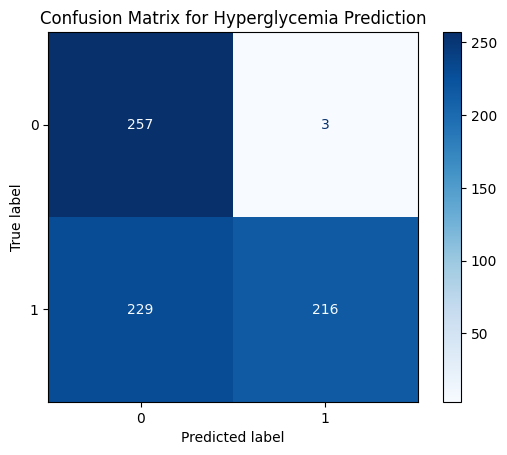


ROC AUC Score:
0.9558815903197926
Number of false negatives: 229
Number of false positives: 3
Number of true positives: 216
Number of true negatives: 257

Example false negatives:
       Glucose_t-105min  BPM_t-105min  Distance_t-105min  Calories_t-105min  \
1295               6.7     64.056450              271.6              19.36   
942               12.6     88.686561               20.8              22.26   
1805               6.5     83.193254              126.5              17.86   
293                6.9     71.003492              145.0              63.65   
680                9.1     75.962614              110.9              17.86   

      Insulin on board_t-105min  COB_t-105min  Glucose_t-90min  BPM_t-90min  \
1295                  12.606600      6.399704              6.8    62.021270   
942                    9.639368     20.540582             11.6    85.799259   
1805                  10.874180      4.046356              6.7    78.212963   
293                   12.154890  

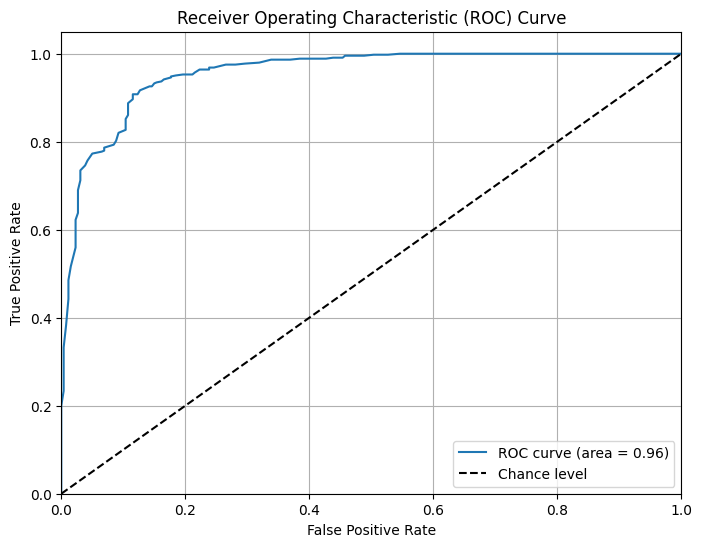

Cutoff 0.1: Precision=0.761, Recall=1.000, F1=0.864
Cutoff 0.3: Precision=0.805, Recall=0.989, F1=0.888
Cutoff 0.5: Precision=0.861, Recall=0.909, F1=0.885
Cutoff 0.7: Precision=0.930, Recall=0.710, F1=0.805
Cutoff 0.9: Precision=0.983, Recall=0.264, F1=0.416
Confusion Matrix:
[[252   2]
 [332 119]]

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.99      0.60       254
           1       0.98      0.26      0.42       451

    accuracy                           0.53       705
   macro avg       0.71      0.63      0.51       705
weighted avg       0.78      0.53      0.48       705



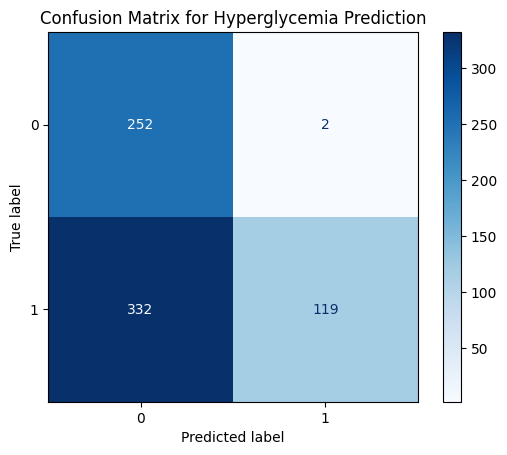


ROC AUC Score:
0.9256376905215007
Number of false negatives: 332
Number of false positives: 2
Number of true positives: 119
Number of true negatives: 252

Example false negatives:
       Glucose_t-105min  BPM_t-105min  Distance_t-105min  Calories_t-105min  \
883                7.6     75.304048               56.8              16.70   
593                3.4     57.659079                4.8              16.52   
1016               5.4     75.481407               90.0              70.33   
189                4.3     81.807568                0.0              17.49   
1816               7.8     83.386946               21.5              17.64   

      Insulin on board_t-105min  COB_t-105min  Glucose_t-90min  BPM_t-90min  \
883                   10.895511  2.098696e+00              7.5    58.377660   
593                   12.908827  4.030506e-06              3.4    59.131852   
1016                  11.051077  6.669365e+00              5.4    76.160236   
189                    8.470413  

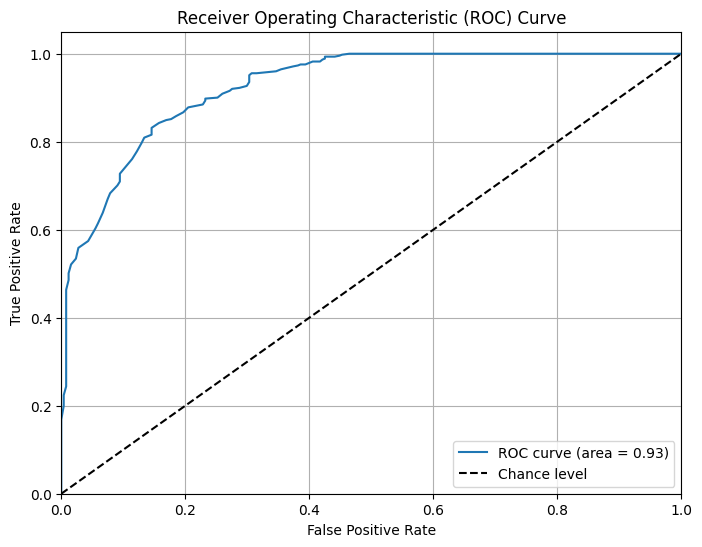

Cutoff 0.1: Precision=0.694, Recall=1.000, F1=0.820
Cutoff 0.3: Precision=0.739, Recall=0.986, F1=0.845
Cutoff 0.5: Precision=0.821, Recall=0.947, F1=0.880
Cutoff 0.7: Precision=0.894, Recall=0.713, F1=0.793
Cutoff 0.9: Precision=1.000, Recall=0.190, F1=0.320
Confusion Matrix:
[[268   0]
 [353  83]]

Classification Report:
              precision    recall  f1-score   support

           0       0.43      1.00      0.60       268
           1       1.00      0.19      0.32       436

    accuracy                           0.50       704
   macro avg       0.72      0.60      0.46       704
weighted avg       0.78      0.50      0.43       704



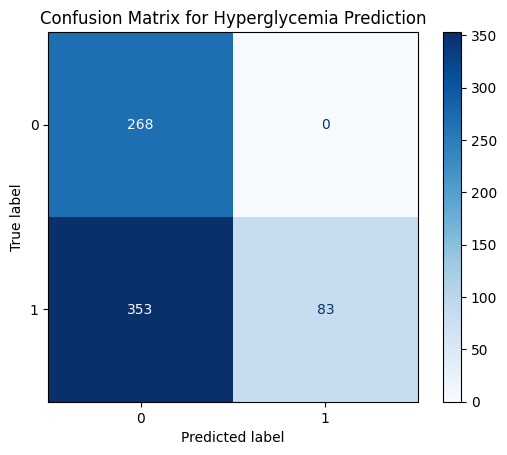


ROC AUC Score:
0.8889454676160482
Number of false negatives: 353
Number of false positives: 0
Number of true positives: 83
Number of true negatives: 268

Example false negatives:
       Glucose_t-105min  BPM_t-105min  Distance_t-105min  Calories_t-105min  \
613                6.5     74.555770                5.5              76.47   
375                6.6     78.413598              107.6              19.45   
2302               8.4     76.985556              312.5              86.04   
1974               7.4     72.884048                0.0              16.30   
1035              13.8     77.581481               45.7              19.05   

      Insulin on board_t-105min  COB_t-105min  Glucose_t-90min  BPM_t-90min  \
613                   14.128812      0.180123              6.5    70.922011   
375                   11.648671      8.777762              6.8    77.539690   
2302                  14.203389      5.625000              8.5    77.734656   
1974                  12.785840   

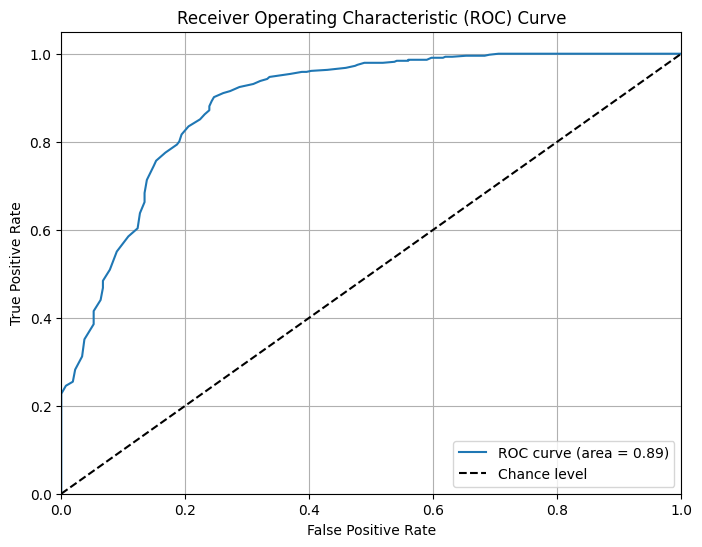

Cutoff 0.1: Precision=0.648, Recall=0.998, F1=0.786
Cutoff 0.3: Precision=0.719, Recall=0.975, F1=0.828
Cutoff 0.5: Precision=0.793, Recall=0.917, F1=0.850
Cutoff 0.7: Precision=0.909, Recall=0.581, F1=0.709
Cutoff 0.9: Precision=1.000, Recall=0.049, F1=0.094
Confusion Matrix:
[[257   0]
 [424  22]]

Classification Report:
              precision    recall  f1-score   support

           0       0.38      1.00      0.55       257
           1       1.00      0.05      0.09       446

    accuracy                           0.40       703
   macro avg       0.69      0.52      0.32       703
weighted avg       0.77      0.40      0.26       703



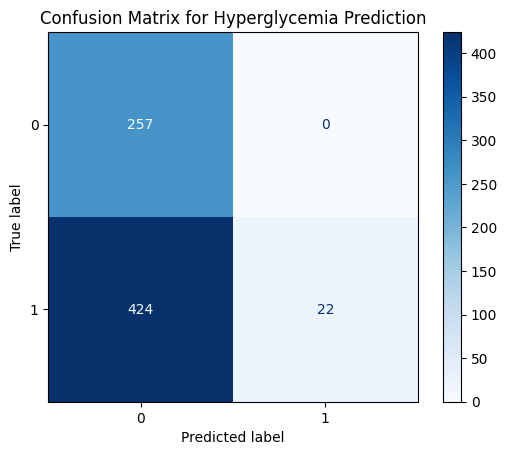


ROC AUC Score:
0.8623911639999302
Number of false negatives: 424
Number of false positives: 0
Number of true positives: 22
Number of true negatives: 257

Example false negatives:
       Glucose_t-105min  BPM_t-105min  Distance_t-105min  Calories_t-105min  \
4                  9.1     62.778730                0.0              21.17   
1090               7.6     84.598016              488.7              22.28   
864               16.0     90.310269                0.0              28.65   
701                6.8     67.549101              577.9              19.91   
1511               8.2     51.512063               11.8              27.02   

      Insulin on board_t-105min  COB_t-105min  Glucose_t-90min  BPM_t-90min  \
4                      0.000000      0.000000              9.3    65.232937   
1090                  13.196792      3.000000              6.8    99.826217   
864                    9.457411      0.729234             15.6    91.413624   
701                   14.132211   

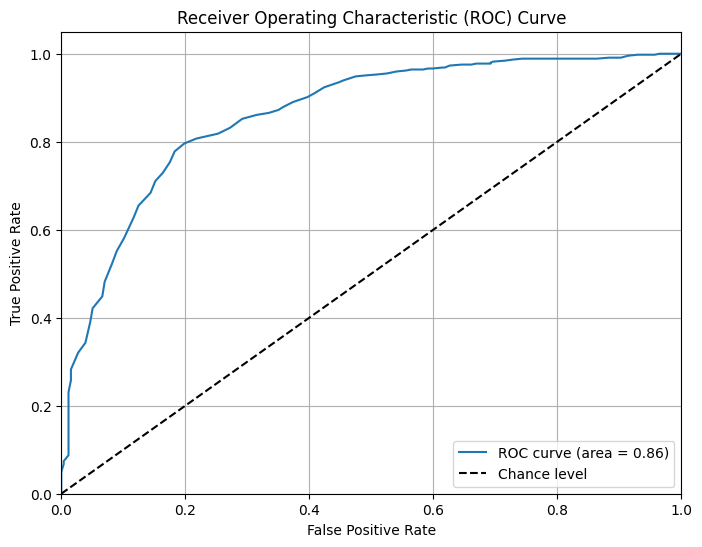

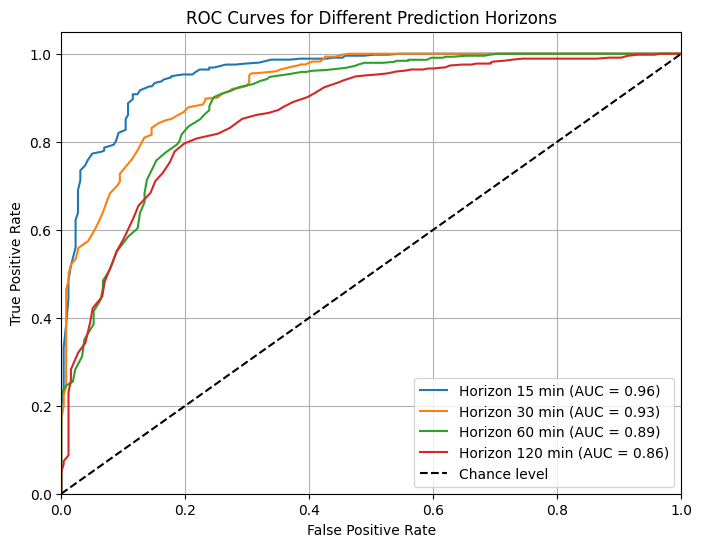

In [48]:
from sklearn.metrics import roc_curve, roc_auc_score

# Store models, test labels, and predicted probabilities
models = {}
y_tests = []
y_probas = []

for horizon in prediction_horizons:
    # Train model for this horizon
    model = train_hyperglycemia(horizon, dfs[horizon])
    models[horizon] = model
    
    # Extract test data for this horizon (assumes data_splits dict exists)
    X_test = data_splits[horizon]['X_test']
    y_test = data_splits[horizon]['y_hyper_test']
    
    # Predict probabilities for positive class
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Append to lists
    y_tests.append(y_test)
    y_probas.append(y_proba)

# Plot ROC curves for all horizons
plot_multiple_roc_curves(y_tests, y_probas, horizons=[f"{h} min" for h in prediction_horizons])





In [49]:
from sklearn.metrics import f1_score, precision_score, recall_score



def train_hypo(prediction_horizon,df):

    #et the data splits from before
    X_train = data_splits[prediction_horizon]['X_train']
    X_test = data_splits[prediction_horizon]['X_test']
    y_train =data_splits[prediction_horizon]['y_hypo_train']
    y_test =  data_splits[prediction_horizon]['y_hypo_test']

    # 3. Initialize and train Random Forest classifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)    

   
    # 4. Predict probabilities on the test set
    y_proba = rf.predict_proba(X_test)[:, 1]  # Probability of positive class (hyperglycemia)

    thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
    best_f1 = 0
    best_thresh = 0.5  # default

    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        print(f"Cutoff {thresh}: Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}")

    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh


    # 5. Convert probabilities to binary predictions using 0.5 cutoff
    y_pred = (y_proba >= best_thresh).astype(int)


    # 6. Evaluate model
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix for Hyperglycemia Prediction")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nROC AUC Score:")
    print(roc_auc_score(y_test, y_proba))

    error_cases_analysis(X_test,y_test,y_pred)

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_score(y_test, y_proba):.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance level')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return rf



Cutoff 0.1: Precision=0.516, Recall=0.889, F1=0.653
Cutoff 0.3: Precision=0.707, Recall=0.806, F1=0.753
Cutoff 0.5: Precision=0.750, Recall=0.750, F1=0.750
Cutoff 0.7: Precision=0.857, Recall=0.667, F1=0.750
Cutoff 0.9: Precision=0.917, Recall=0.306, F1=0.458
Confusion Matrix:
[[668   1]
 [ 25  11]]


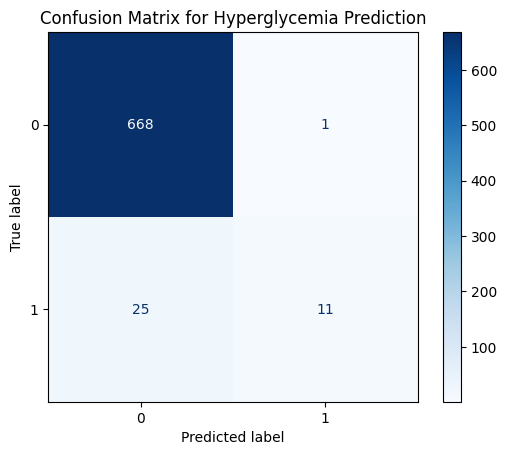


Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       669
           1       0.92      0.31      0.46        36

    accuracy                           0.96       705
   macro avg       0.94      0.65      0.72       705
weighted avg       0.96      0.96      0.95       705


ROC AUC Score:
0.9646238166417538
Number of false negatives: 25
Number of false positives: 1
Number of true positives: 11
Number of true negatives: 668

Example false negatives:
       Glucose_t-105min  BPM_t-105min  Distance_t-105min  Calories_t-105min  \
1762               5.2     56.490556                0.0              16.20   
93                 3.7     54.712011                0.0              16.83   
587                3.7     57.020397                0.0              17.92   
306               12.2    101.136003              298.7              71.51   
581                4.7     53.528333                0.0              16.30   



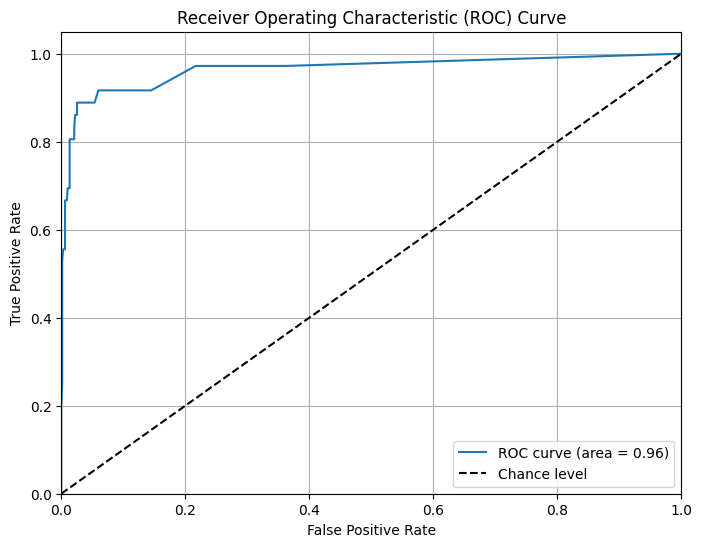

Cutoff 0.1: Precision=0.577, Recall=0.857, F1=0.690
Cutoff 0.3: Precision=0.718, Recall=0.800, F1=0.757
Cutoff 0.5: Precision=0.818, Recall=0.771, F1=0.794
Cutoff 0.7: Precision=0.857, Recall=0.514, F1=0.643
Cutoff 0.9: Precision=0.667, Recall=0.057, F1=0.105
Confusion Matrix:
[[669   1]
 [ 33   2]]


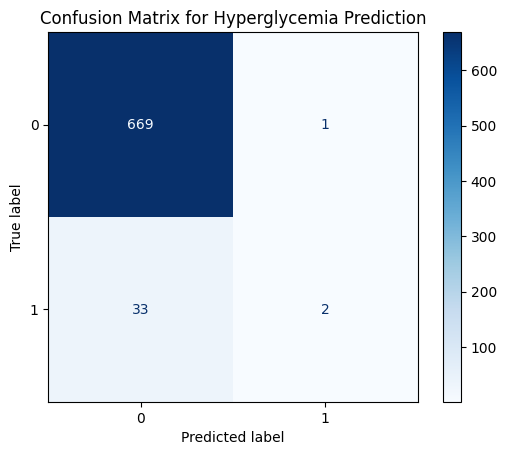


Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       670
           1       0.67      0.06      0.11        35

    accuracy                           0.95       705
   macro avg       0.81      0.53      0.54       705
weighted avg       0.94      0.95      0.93       705


ROC AUC Score:
0.9711087420042643
Number of false negatives: 33
Number of false positives: 1
Number of true positives: 2
Number of true negatives: 669

Example false negatives:
       Glucose_t-105min  BPM_t-105min  Distance_t-105min  Calories_t-105min  \
1702              12.0     87.151426                0.0               16.4   
1893               5.6     74.547196                0.0               16.9   
2122               4.2     57.026287                0.0               16.3   
582                4.4     55.846164                0.0               16.2   
2120               4.3     57.287922                0.0               16.2   

 

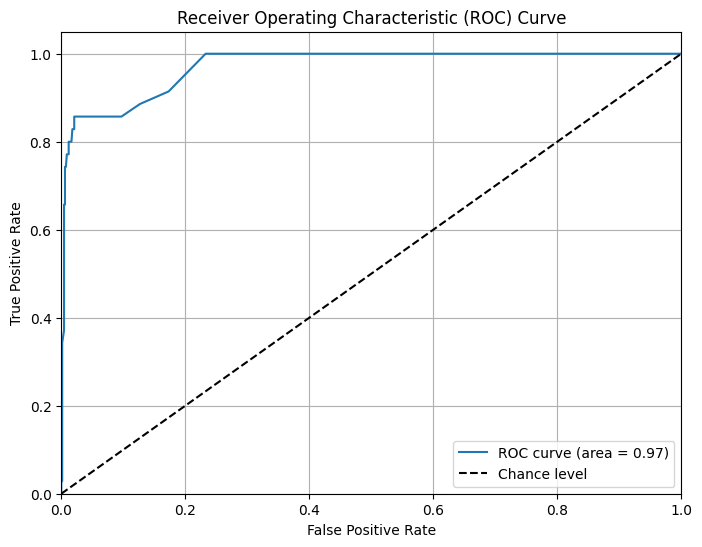

Cutoff 0.1: Precision=0.517, Recall=0.938, F1=0.667
Cutoff 0.3: Precision=0.964, Recall=0.844, F1=0.900
Cutoff 0.5: Precision=0.944, Recall=0.531, F1=0.680
Cutoff 0.7: Precision=1.000, Recall=0.312, F1=0.476
Cutoff 0.9: Precision=1.000, Recall=0.031, F1=0.061
Confusion Matrix:
[[672   0]
 [ 31   1]]


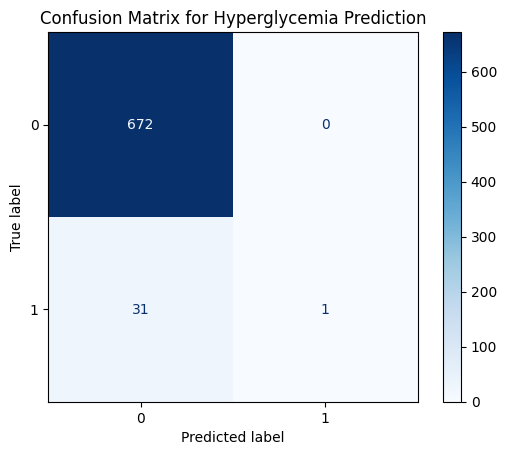


Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       672
           1       1.00      0.03      0.06        32

    accuracy                           0.96       704
   macro avg       0.98      0.52      0.52       704
weighted avg       0.96      0.96      0.94       704


ROC AUC Score:
0.97998046875
Number of false negatives: 31
Number of false positives: 0
Number of true positives: 1
Number of true negatives: 672

Example false negatives:
      Glucose_t-105min  BPM_t-105min  Distance_t-105min  Calories_t-105min  \
161               4.3     52.327460                0.0              16.30   
720               6.8     56.560541                0.0              16.40   
575               6.4     54.555582                0.0              16.20   
488               4.1     54.904603                0.0              16.20   
483               4.8     54.718911                0.0              16.41   

     Insulin

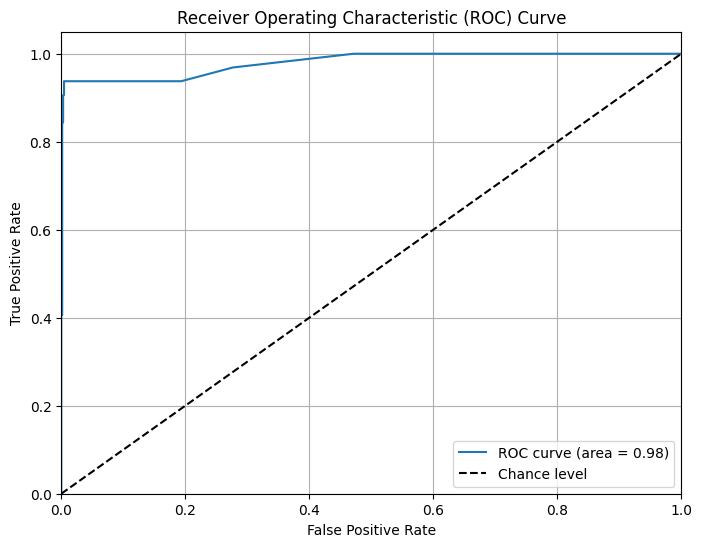

Cutoff 0.1: Precision=0.393, Recall=0.889, F1=0.545
Cutoff 0.3: Precision=0.842, Recall=0.593, F1=0.696
Cutoff 0.5: Precision=1.000, Recall=0.296, F1=0.457
Cutoff 0.7: Precision=1.000, Recall=0.111, F1=0.200
Cutoff 0.9: Precision=0.000, Recall=0.000, F1=0.000
Confusion Matrix:
[[676   0]
 [ 19   8]]


C:\Users\emmxc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


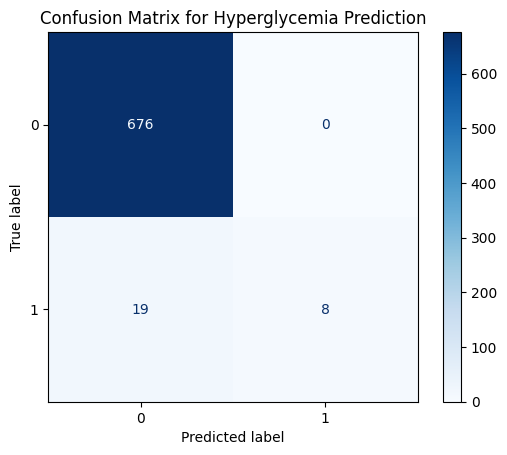


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       676
           1       1.00      0.30      0.46        27

    accuracy                           0.97       703
   macro avg       0.99      0.65      0.72       703
weighted avg       0.97      0.97      0.97       703


ROC AUC Score:
0.9493206223975454
Number of false negatives: 19
Number of false positives: 0
Number of true positives: 8
Number of true negatives: 676

Example false negatives:
       Glucose_t-105min  BPM_t-105min  Distance_t-105min  Calories_t-105min  \
2152              12.7     66.734578               30.2              33.72   
2117               6.1     55.581534                0.0              16.30   
1524               9.4     51.667674                0.0              16.62   
71                13.9     49.152222                0.0              31.43   
148                6.0     90.759127                0.0              46.08   

 

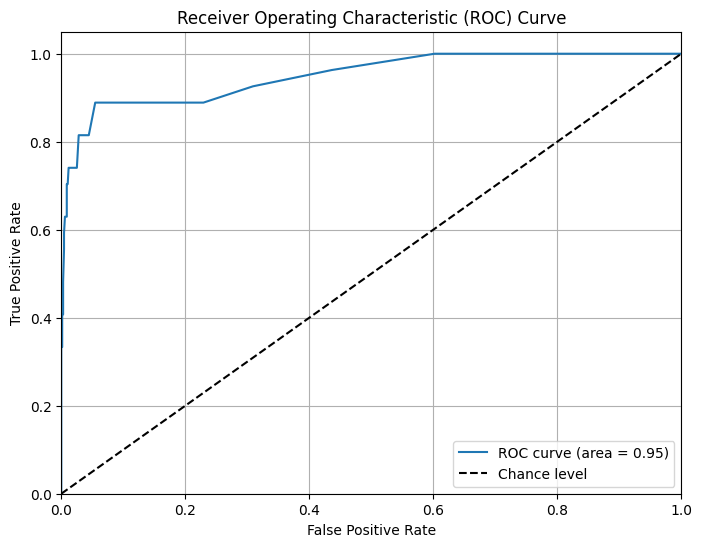

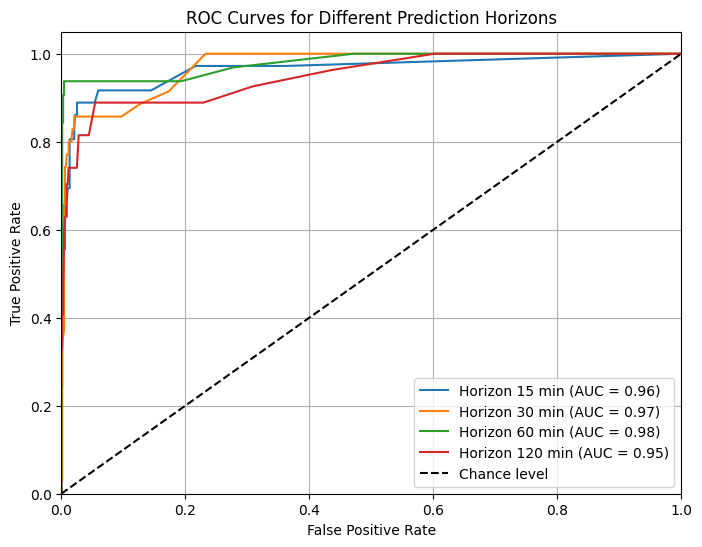

In [50]:
from sklearn.metrics import roc_curve, roc_auc_score

# Store models, test labels, and predicted probabilities
models_2 = {}
y_tests = []
y_probas = []

for horizon in prediction_horizons:
    # Train model for this horizon
    model = train_hypo(horizon, dfs[horizon])
    models_2[horizon] = model
    
    # Extract test data for this horizon (assumes data_splits dict exists)
    X_test = data_splits[horizon]['X_test']
    y_test = data_splits[horizon]['y_hypo_test']
    
    # Predict probabilities for positive class
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Append to lists
    y_tests.append(y_test)
    y_probas.append(y_proba)

# Plot ROC curves for all horizons
plot_multiple_roc_curves(y_tests, y_probas, horizons=[f"{h} min" for h in prediction_horizons])



JUSTIFY THE HYPOGLYCEMIA BEING BETTER IN OUR CASE

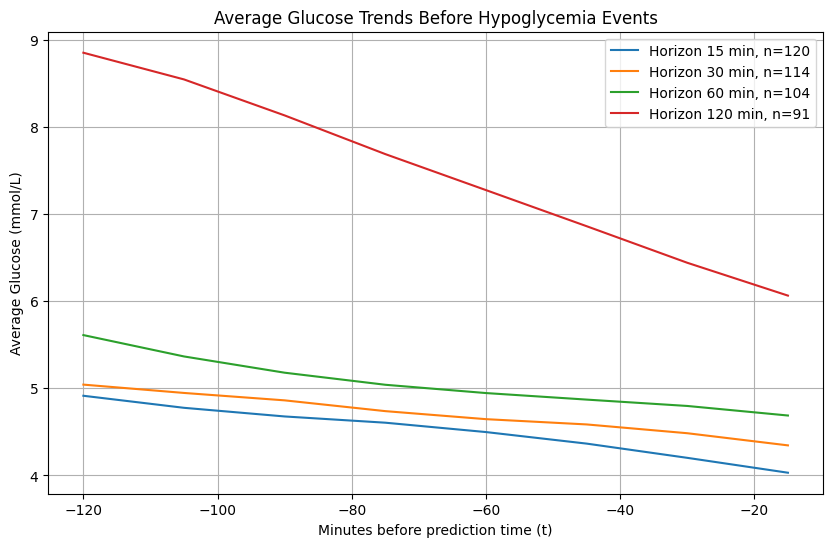

In [51]:
import matplotlib.pyplot as plt
import numpy as np

def plot_glucose_trends(df, prediction_horizons, window_size=8, feature='Glucose'):
    """
    Plot average glucose trends over the past window_size points leading to hypoglycemia
    at different prediction horizons.
    """
    plt.figure(figsize=(10, 6))
    
    for horizon in prediction_horizons:
        step_ahead = horizon // 15
        df_sorted = df.sort_values('Time').reset_index(drop=True)
        df_sorted['Glucose_future'] = df_sorted['Glucose'].shift(-step_ahead)
        df_sorted['Hypoglycemia'] = (df_sorted['Glucose_future'] < 3.9).astype(int)

        # Collect windows leading to hypoglycemia
        windows = []
        for i in range(window_size, len(df_sorted) - step_ahead):
            if df_sorted.iloc[i + step_ahead]['Hypoglycemia'] == 1:
                window_values = df_sorted.iloc[i - window_size:i][feature].values
                if not np.isnan(window_values).any():
                    windows.append(window_values)

        if len(windows) == 0:
            print(f"No hypoglycemia windows found for horizon {horizon}")
            continue

        avg_trend = np.mean(windows, axis=0)
        time_points = [-(window_size - j) * 15 for j in range(window_size)]  # e.g., -120, -105, ..., -15 mins

        plt.plot(time_points, avg_trend, label=f'Horizon {horizon} min, n={len(windows)}')

    plt.xlabel('Minutes before prediction time (t)')
    plt.ylabel('Average Glucose (mmol/L)')
    plt.title('Average Glucose Trends Before Hypoglycemia Events')
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage example:
plot_glucose_trends(df, prediction_horizons=[15, 30, 60, 120])


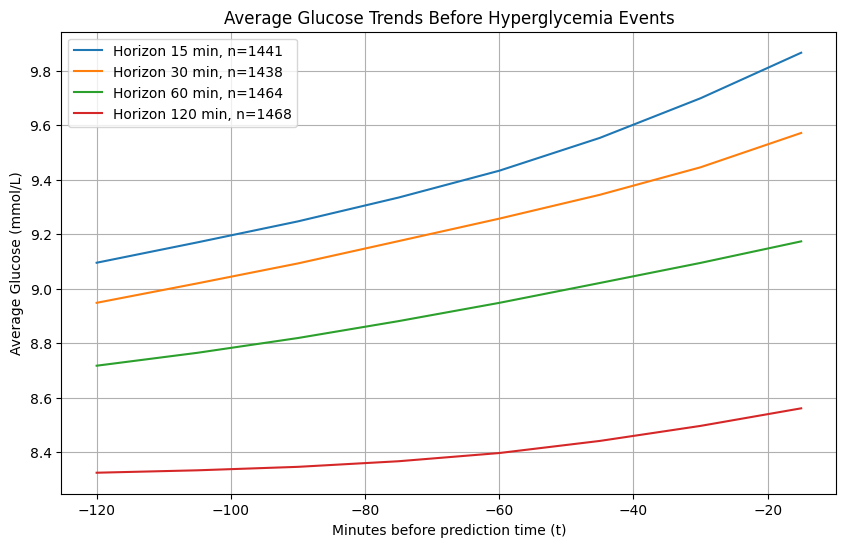

In [52]:
import matplotlib.pyplot as plt
import numpy as np

def plot_glucose_trends(df, prediction_horizons, window_size=8, feature='Glucose'):
    """
    Plot average glucose trends over the past window_size points leading to hypoglycemia
    at different prediction horizons.
    """
    plt.figure(figsize=(10, 6))
    
    for horizon in prediction_horizons:
        step_ahead = horizon // 15
        df_sorted = df.sort_values('Time').reset_index(drop=True)
        df_sorted['Glucose_future'] = df_sorted['Glucose'].shift(-step_ahead)
        df_sorted['Hyperglycemia'] = (df_sorted['Glucose_future'] > 6.9).astype(int)

        # Collect windows leading to hypoglycemia
        windows = []
        for i in range(window_size, len(df_sorted) - step_ahead):
            if df_sorted.iloc[i + step_ahead]['Hyperglycemia'] == 1:
                window_values = df_sorted.iloc[i - window_size:i][feature].values
                if not np.isnan(window_values).any():
                    windows.append(window_values)

        if len(windows) == 0:
            print(f"No Hyperglycemia windows found for horizon {horizon}")
            continue

        avg_trend = np.mean(windows, axis=0)
        time_points = [-(window_size - j) * 15 for j in range(window_size)]  # e.g., -120, -105, ..., -15 mins

        plt.plot(time_points, avg_trend, label=f'Horizon {horizon} min, n={len(windows)}')

    plt.xlabel('Minutes before prediction time (t)')
    plt.ylabel('Average Glucose (mmol/L)')
    plt.title('Average Glucose Trends Before Hyperglycemia Events')
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage example:
plot_glucose_trends(df, prediction_horizons=[15, 30, 60, 120])


Now the explanations and evaluations of them, i already have the true positive, true negatives, false positive, false negatives cases for hyperglycemia and hypoglycemia so i can use those and the explanation output to see how good it is.

NOTE my explanations are built to explain the high probability of  risk episode they are not so adapted to explain the low probability of it

In [53]:
def get_base_name(feat_name):
    prefixes = ["Glucose", "Insulin on board", "COB", "Calories", "Distance", "BPM"]
    for prefix in prefixes:
        if feat_name.startswith(prefix):
            return prefix
    return feat_name


In [54]:
def SHAP_withrepetitions(model,input_row,horizon,label,count_limit,class_label):

    highest_shap = 0
    
    df_temp = dfs[horizon]
    if (label == "hyper"):
        explainer = shap.TreeExplainer(models[horizon]) 
    
    if (label == "hypo"):
        explainer = shap.TreeExplainer(models_2[horizon]) 
    
    print(input_row)
    
    # Get SHAP values for input_row
    shap_values = explainer.shap_values(input_row)

    print(shap_values[0])

    print(f"Top {count_limit} features for class {class_label} by absolute SHAP value (with counts for repeated base names):")

    seen = {}
    printed = 0
    i = 0
    while printed < count_limit and i < len(highest_shap):
        abs_val, val, feat = highest_shap[i]
        base_name = get_base_name(feat)
        seen[base_name] = seen.get(base_name, 0) + 1
        suffix = f" ({seen[base_name]})" if seen[base_name] > 1 else ""
        print(f"{printed+1}. {feat}{suffix}: SHAP value = {val:.4f}")
        printed += 1
        i += 1
    

In [55]:
df_temp = dfs[15]
input_row = df_temp.iloc[[30]]

print(input_row)
explainer = shap.TreeExplainer(models[15])

# Get SHAP values for input_row
shap_values = explainer.shap_values(input_row)
 

def get_base_name(feat_name):
    # Extract base feature name by matching known prefixes
    prefixes = ["Glucose", "Insulin on board", "COB", "Calories", "Distance", "BPM"]
    for prefix in prefixes:
        if feat_name.startswith(prefix):
            return prefix
    return feat_name  # fallback if no prefix matches

highest_shap_0 = []  # (abs_shap_val, shap_val, feat_name)
highest_shap_1 = []

for i in range(len(input_row.columns)):
    feat_name = input_row.columns[i]
    shap_val = shap_values[0][i]  # [class_0_shap, class_1_shap]

    shap_val_0 = shap_val[0]  # Class 0 SHAP
    shap_val_1 = shap_val[1]  # Class 1 SHAP

    highest_shap_0.append((abs(shap_val_0), shap_val_0, feat_name))
    highest_shap_1.append((abs(shap_val_1), shap_val_1, feat_name))

highest_shap_0.sort(key=lambda x: x[0], reverse=True)
highest_shap_1.sort(key=lambda x: x[0], reverse=True)
def get_base_name(feat_name):
    prefixes = ["Glucose", "Insulin on board", "COB", "Calories", "Distance", "BPM"]
    for prefix in prefixes:
        if feat_name.startswith(prefix):
            return prefix
    return feat_name

def print_top_with_counts(highest_shap, class_label, count_limit=5):
    print(f"Top {count_limit} features for class {class_label} by absolute SHAP value (with counts for repeated base names):")

    seen = {}
    printed = 0
    i = 0
    while printed < count_limit and i < len(highest_shap):
        abs_val, val, feat = highest_shap[i]
        base_name = get_base_name(feat)
        seen[base_name] = seen.get(base_name, 0) + 1
        suffix = f" ({seen[base_name]})" if seen[base_name] > 1 else ""
        print(f"{printed+1}. {feat}{suffix}: SHAP value = {val:.4f}")
        printed += 1
        i += 1

def print_top_distinct_base_names(highest_shap, class_label, distinct_limit=5):
    print(f"\nTop {distinct_limit} distinct base name features for class {class_label} by absolute SHAP value:")

    seen = set()
    printed = 0
    i = 0
    while printed < distinct_limit and i < len(highest_shap):
        abs_val, val, feat = highest_shap[i]
        base_name = get_base_name(feat)
        if base_name not in seen:
            print(f"{printed+1}. {feat}: SHAP value = {val:.4f}")
            seen.add(base_name)
            printed += 1
        i += 1

# Example usage after sorting highest_shap_0 and highest_shap_1:
print_top_with_counts(highest_shap_0, class_label=0)
print_top_distinct_base_names(highest_shap_0, class_label=0)

print("\n")

print_top_with_counts(highest_shap_1, class_label=1)
print_top_distinct_base_names(highest_shap_1, class_label=1)


    Glucose_t-105min  BPM_t-105min  Distance_t-105min  Calories_t-105min  \
30               7.2     79.668824              227.9              75.81   

    Insulin on board_t-105min  COB_t-105min  Glucose_t-90min  BPM_t-90min  \
30                   1.486208      3.777686              7.7    72.318413   

    Distance_t-90min  Calories_t-90min  ...  Insulin on board_t-15min  \
30              19.3             49.33  ...                  2.188631   

    COB_t-15min  Glucose_t-0min  BPM_t-0min  Distance_t-0min  Calories_t-0min  \
30     3.483026            11.9   72.286667              0.0            18.83   

    Insulin on board_t-0min  COB_t-0min  Outcome_Hyperglycemia  \
30                  2.25338    4.078751                      1   

    Outcome_Hypoglycemia  
30                     0  

[1 rows x 50 columns]
Top 5 features for class 0 by absolute SHAP value (with counts for repeated base names):
1. Glucose_t-0min: SHAP value = -0.1381
2. Glucose_t-15min (2): SHAP value = -0.060

In [56]:

def Explainer(df,model):

    df_temp = df
    explainer = shap.TreeExplainer(model)

    def analyze_row_shap(row):
        # row is a single-row DataFrame, shape (1, n_features)
        shap_values = explainer.shap_values(row)

        highest_shap_0 = []
        highest_shap_1 = []

        for i in range(len(row.columns)):
            feat_name = row.columns[i]
            shap_val = shap_values[0][i]  # [class_0_shap, class_1_shap]

            shap_val_0 = shap_val[0]
            shap_val_1 = shap_val[1]

            highest_shap_0.append((abs(shap_val_0), shap_val_0, feat_name))
            highest_shap_1.append((abs(shap_val_1), shap_val_1, feat_name))

        highest_shap_0.sort(key=lambda x: x[0], reverse=True)
        highest_shap_1.sort(key=lambda x: x[0], reverse=True)

        print(f"\n--- SHAP analysis for sample index {row.index[0]} ---")

        print_top_with_counts(highest_shap_0, class_label=0)
        print_top_distinct_base_names(highest_shap_0, class_label=0)

        print("\n")

        print_top_with_counts(highest_shap_1, class_label=1)
        print_top_distinct_base_names(highest_shap_1, class_label=1)
        print("\n\n")


    # Loop over rows in df_temp, analyze each
    for idx in df_temp.index:
        row = df_temp.loc[[idx]]  # keep as DataFrame with one row
        analyze_row_shap(row)


In [61]:
def run_explainer_for_time_and_horizon(dfs, models_hyper, models_hypo, index, prediction_horizon):
    print(f"\n\n===== Horizon: {prediction_horizon} minutes =====")

    df_temp = dfs[prediction_horizon]
    
    # Filter df_temp for the given time_point
    df_filtered = df_temp.iloc[[index]]
    if df_filtered.empty:
        print(f"No rows found for index {index} at horizon {prediction_horizon}")
        return

    # Print the current row as "column: value" pairs
    print(f"\nRow at index {index}:")
    for col in df_filtered.columns:
        val = df_filtered.iloc[0][col]
        print(f"{col}: {val}")

    X_input = df_filtered.drop(columns=['Outcome_Hyperglycemia', 'Outcome_Hypoglycemia'])

    print("Predicted hyperglycemia probability:")
    y_proba_hyper = models_hyper[prediction_horizon].predict_proba(X_input)[:, 1]
    print(y_proba_hyper)

    print("Actual hyperglycemia outcome:")
    print(df_filtered['Outcome_Hyperglycemia'].values)

    print("Predicted hypoglycemia probability:")
    y_proba_hypo = models_hypo[prediction_horizon].predict_proba(X_input)[:, 1]
    print(y_proba_hypo)

    print("Actual hypoglycemia outcome:")
    print(df_filtered['Outcome_Hypoglycemia'].values)


    
    print(f"\n\n===== Hyperglycemia predictor =====")
    Explainer(df_filtered, models_hyper[prediction_horizon])

    print(f"\n\n===== Hypoglycemia predictor =====")
    Explainer(df_filtered, models_hypo[prediction_horizon])


# Example call:
import pandas as pd
index = 1816
run_explainer_for_time_and_horizon(dfs, models, models_2, index, 30)





===== Horizon: 30 minutes =====

Row at index 1816:
Glucose_t-105min: 7.8
BPM_t-105min: 83.38694638694639
Distance_t-105min: 21.5
Calories_t-105min: 17.64
Insulin on board_t-105min: 13.460879244047405
COB_t-105min: 12.37576596490103
Glucose_t-90min: 8.5
BPM_t-90min: 84.90576719576718
Distance_t-90min: 23.4
Calories_t-90min: 27.58
Insulin on board_t-90min: 13.575036814096164
COB_t-90min: 11.60205982179675
Glucose_t-75min: 8.1
BPM_t-75min: 88.53309523809524
Distance_t-75min: 6.1
Calories_t-75min: 30.61
Insulin on board_t-75min: 13.65975283888036
COB_t-75min: 15.668291197206472
Glucose_t-60min: 7.1
BPM_t-60min: 93.10578162578165
Distance_t-60min: 24.9
Calories_t-60min: 17.36
Insulin on board_t-60min: 13.717603288807398
COB_t-60min: 20.453309378618734
Glucose_t-45min: 6.1
BPM_t-45min: 100.20821548821549
Distance_t-45min: 4.8
Calories_t-45min: 20.9
Insulin on board_t-45min: 13.750977410053066
COB_t-45min: 20.64621047436464
Glucose_t-30min: 5.9
BPM_t-30min: 91.69910533910532
Distance_t-30m